<a href="https://colab.research.google.com/github/cy-fahad/British-library-austerity-analysis-/blob/main/Tech%20%26%20Sci%20topic_modeling_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Step 1: Data Loading and Initial Exploration
# Run this cell first to load and explore our focused dataset

import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Define our target newsgroups for tech vs science analysis
tech_categories = ['comp.graphics', 'comp.windows.x', 'comp.sys.mac.hardware']
science_categories = ['sci.space', 'sci.med', 'sci.electronics']

target_categories = tech_categories + science_categories

print("Loading 20newsgroups dataset...")
print(f"Target categories: {target_categories}")

Loading 20newsgroups dataset...
Target categories: ['comp.graphics', 'comp.windows.x', 'comp.sys.mac.hardware', 'sci.space', 'sci.med', 'sci.electronics']


In [4]:
# Load the dataset with only our target categories
newsgroups_data = fetch_20newsgroups(
    subset='all',  # Get both train and test data
    categories=target_categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers', 'quotes')  # Clean up the text
)

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'text': newsgroups_data.data,
    'category': [newsgroups_data.target_names[i] for i in newsgroups_data.target],
    'domain': ['Technology' if cat.startswith('comp.') else 'Science'
               for cat in [newsgroups_data.target_names[i] for i in newsgroups_data.target]]
})

print(f"\nDataset loaded successfully!")
print(f"Total documents: {len(df)}")
print(f"Categories distribution:")
print(df['category'].value_counts())

print(f"\nDomain distribution:")
print(df['domain'].value_counts())


Dataset loaded successfully!
Total documents: 5885
Categories distribution:
category
sci.med                  990
comp.windows.x           988
sci.space                987
sci.electronics          984
comp.graphics            973
comp.sys.mac.hardware    963
Name: count, dtype: int64

Domain distribution:
domain
Science       2961
Technology    2924
Name: count, dtype: int64


In [5]:
# Show sample documents
print(f"\nSample documents:")
for i, (domain, group) in enumerate(df.groupby('domain')):
    print(f"\n=== {domain.upper()} SAMPLE ===")
    sample_text = group.iloc[0]['text'][:300] + "..."
    print(f"Category: {group.iloc[0]['category']}")
    print(f"Text: {sample_text}")
    if i >= 1:  # Show only 2 samples
        break



Sample documents:

=== SCIENCE SAMPLE ===
Category: sci.electronics
Text: 


That is an exceptionally cool idea.
Would it work?

How strong a field is needed?
Anyone?

...

=== TECHNOLOGY SAMPLE ===
Category: comp.windows.x
Text: Can anyone help with this?

System: SPARC Classic, Solaris 2.1, gcc 2.3.3, X11R5

When I try to build the XView libraries (xview3, patched with the patch from
the X11R5-Solaris kit), I get the following error:

rm -f ndet_loop.o shared/ndet_loop.o
gcc -fpcc-struct-return -E   -O2  -I../../.././build...


In [6]:
# Basic text statistics
df['text_length'] = df['text'].str.len()
print(f"\nText length statistics:")
print(df.groupby('domain')['text_length'].describe())



Text length statistics:
             count         mean          std  min    25%    50%    75%  \
domain                                                                   
Science     2961.0  1079.683891  3104.369785  0.0  258.0  510.0  935.0   
Technology  2924.0  1144.841997  4840.421694  0.0  224.0  415.5  777.0   

                max  
domain               
Science     72161.0  
Technology  65424.0  


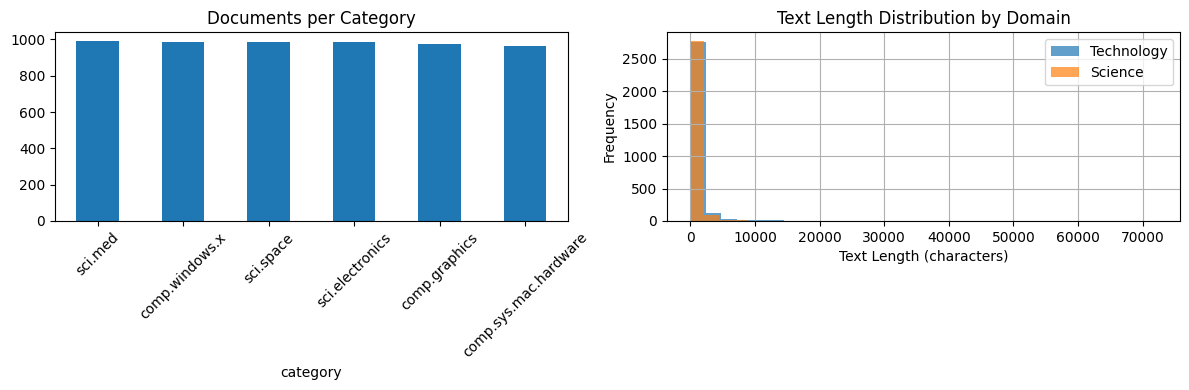


✅ Data loading complete! Ready for preprocessing.
Next step: Text preprocessing with spaCy


In [7]:
# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['category'].value_counts().plot(kind='bar', rot=45)
plt.title('Documents per Category')
plt.tight_layout()

plt.subplot(1, 2, 2)
df.groupby('domain')['text_length'].hist(alpha=0.7, bins=30)
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Text Length Distribution by Domain')
plt.legend(['Technology', 'Science'])
plt.tight_layout()

plt.show()

print(f"\n✅ Data loading complete! Ready for preprocessing.")
print(f"Next step: Text preprocessing with spaCy")

In [8]:
# Step 2: Text Preprocessing with spaCy
# This will clean and prepare our text for topic modeling

import spacy
import re
from collections import Counter

# Install required packages (run only if needed)
# !pip install spacy
# !python -m spacy download en_core_web_sm

print("Loading spaCy model...")
try:
    nlp = spacy.load("en_core_web_sm")
    print("✅ spaCy model loaded successfully!")
except OSError:
    print("Installing spaCy English model...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Basic cleaning
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if len(text) < 50:
        return []

    doc = nlp(text)

    tokens = []
    for token in doc:
        if (not token.is_stop and
            not token.is_punct and
            not token.is_space and
            len(token.text) > 2 and
            token.pos_ in ['NOUN', 'ADJ', 'VERB'] and
            token.is_alpha):
            tokens.append(token.lemma_.lower())

    return tokens

print("Preprocessing texts... This may take 2-3 minutes")

processed_texts = []
valid_indices = []

for idx, text in enumerate(df['text']):
    tokens = preprocess_text(text)
    if len(tokens) >= 5:
        processed_texts.append(tokens)
        valid_indices.append(idx)

    if (idx + 1) % 1000 == 0:
        print(f"Processed {idx + 1}/{len(df)} documents...")

df_processed = df.iloc[valid_indices].copy()
df_processed['processed_tokens'] = processed_texts

print(f"\n✅ Preprocessing complete!")
print(f"Documents before: {len(df)}")
print(f"Documents after: {len(df_processed)}")

print(f"\nSample processed documents:")
for i in range(2):
    print(f"\nCategory: {df_processed.iloc[i]['category']}")
    print(f"Processed tokens (first 15): {df_processed.iloc[i]['processed_tokens'][:15]}")

all_tokens = [token for tokens in processed_texts for token in tokens]
vocab_counter = Counter(all_tokens)

print(f"\nVocabulary Statistics:")
print(f"Total tokens: {len(all_tokens):,}")
print(f"Unique tokens: {len(vocab_counter):,}")
print(f"Average tokens per document: {len(all_tokens)/len(processed_texts):.1f}")

print(f"\nMost common tokens:")
for token, count in vocab_counter.most_common(15):
    print(f"  {token}: {count}")

print(f"\n✅ Ready for topic modeling!")

Loading spaCy model...
✅ spaCy model loaded successfully!
Preprocessing texts... This may take 2-3 minutes
Processed 1000/5885 documents...
Processed 2000/5885 documents...
Processed 3000/5885 documents...
Processed 4000/5885 documents...
Processed 5000/5885 documents...

✅ Preprocessing complete!
Documents before: 5885
Documents after: 5442

Sample processed documents:

Category: comp.windows.x
Processed tokens (first 15): ['help', 'system', 'sparc', 'gcc', 'try', 'build', 'library', 'patch', 'patch', 'kit', 'follow', 'error', 'share', 'ndet', 'struct']

Category: sci.electronics
Processed tokens (first 15): ['cool', 'idea', 'work', 'strong', 'field', 'need']

Vocabulary Statistics:
Total tokens: 363,883
Unique tokens: 19,660
Average tokens per document: 66.9

Most common tokens:
  use: 2606
  file: 2271
  know: 2045
  image: 1887
  program: 1877
  work: 1789
  time: 1609
  problem: 1551
  system: 1477
  need: 1434
  find: 1386
  include: 1373
  run: 1368
  good: 1346
  look: 1289

✅ 

In [8]:
# Step 3: Topic Modeling with Gensim LDA
# Create document-term matrix and run LDA topic modeling

import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import warnings
warnings.filterwarnings('ignore')

print("Creating document-term matrix...")

Creating document-term matrix...


In [9]:
def preprocess_text(text):
    # Basic cleaning
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if len(text) < 50:
        return []

    doc = nlp(text)

    # Extract relevant tokens
    tokens = []
    for token in doc:
        # Keep only meaningful tokens
        if (not token.is_stop and           # Not a stopword
            not token.is_punct and          # Not punctuation
            not token.is_space and          # Not whitespace
            len(token.text) > 2 and         # At least 3 characters
            token.pos_ in ['NOUN', 'ADJ', 'VERB'] and  # Relevant POS tags
            token.is_alpha):                # Only alphabetic

            # Use lemma (root form)
            tokens.append(token.lemma_.lower())

    return tokens

print("Preprocessing texts... This may take 2-3 minutes for 5,885 documents")

# Apply preprocessing to all texts
processed_texts = []
valid_indices = []

for idx, text in enumerate(df['text']):
    tokens = preprocess_text(text)
    if len(tokens) >= 5:  # Keep documents with at least 5 meaningful tokens
        processed_texts.append(tokens)
        valid_indices.append(idx)

    if (idx + 1) % 1000 == 0:
        print(f"Processed {idx + 1}/{len(df)} documents...")

df_processed = df.iloc[valid_indices].copy()
df_processed['processed_tokens'] = processed_texts

print(f"\n✅ Preprocessing complete!")
print(f"Documents before: {len(df)}")
print(f"Documents after: {len(df_processed)}")

print(f"\nSample processed documents:")
for i in range(2):
    print(f"\nCategory: {df_processed.iloc[i]['category']}")
    print(f"Processed tokens (first 15): {df_processed.iloc[i]['processed_tokens'][:15]}")

all_tokens = [token for tokens in processed_texts for token in tokens]
vocab_counter = Counter(all_tokens)

print(f"\nVocabulary Statistics:")
print(f"Total tokens: {len(all_tokens):,}")
print(f"Unique tokens: {len(vocab_counter):,}")
print(f"Average tokens per document: {len(all_tokens)/len(processed_texts):.1f}")

print(f"\nMost common tokens:")
for token, count in vocab_counter.most_common(15):
    print(f"  {token}: {count}")

print(f"\n✅ Ready for topic modeling!")

Preprocessing texts... This may take 2-3 minutes for 5,885 documents
Processed 1000/5885 documents...
Processed 2000/5885 documents...
Processed 3000/5885 documents...
Processed 4000/5885 documents...
Processed 5000/5885 documents...

✅ Preprocessing complete!
Documents before: 5885
Documents after: 5442

Sample processed documents:

Category: comp.windows.x
Processed tokens (first 15): ['help', 'system', 'sparc', 'gcc', 'try', 'build', 'library', 'patch', 'patch', 'kit', 'follow', 'error', 'share', 'ndet', 'struct']

Category: sci.electronics
Processed tokens (first 15): ['cool', 'idea', 'work', 'strong', 'field', 'need']

Vocabulary Statistics:
Total tokens: 363,883
Unique tokens: 19,660
Average tokens per document: 66.9

Most common tokens:
  use: 2606
  file: 2271
  know: 2045
  image: 1887
  program: 1877
  work: 1789
  time: 1609
  problem: 1551
  system: 1477
  need: 1434
  find: 1386
  include: 1373
  run: 1368
  good: 1346
  look: 1289

✅ Ready for topic modeling!


In [12]:
# Install the gensim library
!pip install gensim

In [14]:
import gensim
from gensim import corpora, models

# Create dictionary (vocabulary)
dictionary = gensim.corpora.Dictionary(processed_texts)
print(f"Dictionary created with {len(dictionary)} unique tokens")

# Filter extremes to improve topic quality
# Remove words that appear in less than 10 documents OR more than 50% of documents
dictionary.filter_extremes(no_below=10, no_above=0.5)
print(f"After filtering: {len(dictionary)} unique tokens")

# Create corpus (document-term matrix)
corpus = [dictionary.doc2bow(doc) for doc in processed_texts]
print(f"Corpus created with {len(corpus)} documents")

# Show sample document representation
print(f"\nSample document as bag-of-words (first 10 terms):")
sample_bow = corpus[0][:10]
for word_id, freq in sample_bow:
    print(f"  '{dictionary[word_id]}': {freq}")

print(f"\n" + "="*50)
print("RUNNING LDA TOPIC MODELING")
print("="*50)

Dictionary created with 19660 unique tokens
After filtering: 3214 unique tokens
Corpus created with 5442 documents

Sample document as bag-of-words (first 10 terms):
  'act': 1
  'appear': 2
  'appreciate': 1
  'approach': 1
  'beauty': 1
  'build': 15
  'cast': 2
  'change': 2
  'class': 8
  'code': 2

RUNNING LDA TOPIC MODELING


In [16]:
from gensim.models.coherencemodel import CoherenceModel
import gensim
from gensim import corpora, models
import warnings
warnings.filterwarnings('ignore')

# Try different numbers of topics to find optimal
topic_numbers = [6, 8, 10]
models_results = {}

for num_topics in topic_numbers:
    print(f"\nTraining LDA model with {num_topics} topics...")

    # Train LDA model
    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha='auto',
        per_word_topics=True,
        minimum_probability=0.01
    )

    # Calculate coherence score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=processed_texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()

    models_results[num_topics] = {
        'model': lda_model,
        'coherence': coherence_score
    }

    print(f"  Coherence score: {coherence_score:.4f}")


Training LDA model with 6 topics...
  Coherence score: 0.4843

Training LDA model with 8 topics...
  Coherence score: 0.5395

Training LDA model with 10 topics...
  Coherence score: 0.5089


In [17]:
# Select best model based on coherence
best_num_topics = max(models_results.keys(), key=lambda k: models_results[k]['coherence'])
best_model = models_results[best_num_topics]['model']
best_coherence = models_results[best_num_topics]['coherence']

print(f"\n🏆 BEST MODEL: {best_num_topics} topics (coherence: {best_coherence:.4f})")

print(f"\n" + "="*50)
print("TOPIC ANALYSIS RESULTS")
print("="*50)

# Display topics with their top words
print(f"\nTop words for each topic:")
for topic_id in range(best_num_topics):
    topic_words = best_model.show_topic(topic_id, topn=10)
    words = [word for word, prob in topic_words]
    probs = [prob for word, prob in topic_words]

    print(f"\nTopic {topic_id}:")
    print(f"  Top words: {', '.join(words[:8])}")
    print(f"  Word probabilities: {[f'{p:.3f}' for p in probs[:5]]}")

# Analyze document-topic distributions
print(f"\n" + "="*30)
print("DOCUMENT-TOPIC ANALYSIS")
print("="*30)


🏆 BEST MODEL: 8 topics (coherence: 0.5395)

TOPIC ANALYSIS RESULTS

Top words for each topic:

Topic 0:
  Top words: window, run, use, server, work, display, application, card
  Word probabilities: ['0.021', '0.016', '0.013', '0.012', '0.012']

Topic 1:
  Top words: patient, people, know, year, cause, disease, doctor, think
  Word probabilities: ['0.008', '0.008', '0.007', '0.007', '0.007']

Topic 2:
  Top words: available, include, file, image, list, graphic, pub, source
  Word probabilities: ['0.019', '0.016', '0.013', '0.012', '0.012']

Topic 3:
  Top words: file, entry, program, output, line, widget, use, set
  Word probabilities: ['0.024', '0.019', '0.018', '0.017', '0.014']

Topic 4:
  Top words: space, launch, year, orbit, satellite, mission, system, time
  Word probabilities: ['0.018', '0.011', '0.010', '0.009', '0.008']

Topic 5:
  Top words: image, file, color, format, bit, program, jpeg, display
  Word probabilities: ['0.042', '0.029', '0.021', '0.017', '0.016']

Topic 6:
 

In [18]:
# Get topic predictions for all documents
doc_topics = []
for doc_bow in corpus:
    doc_topic_dist = best_model.get_document_topics(doc_bow, minimum_probability=0.01)
    # Get dominant topic (highest probability)
    if doc_topic_dist:
        dominant_topic = max(doc_topic_dist, key=lambda x: x[1])
        doc_topics.append(dominant_topic[0])
    else:
        doc_topics.append(-1)  # No clear topic

# Add predictions to dataframe
df_processed['predicted_topic'] = doc_topics

# Analyze topic distribution by original categories
print(f"\nTopic distribution by newsgroup category:")
topic_category_crosstab = pd.crosstab(
    df_processed['category'],
    df_processed['predicted_topic'],
    margins=True
)
print(topic_category_crosstab)

print(f"\nTopic distribution by domain (Tech vs Science):")
topic_domain_crosstab = pd.crosstab(
    df_processed['domain'],
    df_processed['predicted_topic'],
    margins=True
)
print(topic_domain_crosstab)



Topic distribution by newsgroup category:
predicted_topic          0    1    2    3    4    5    6     7   All
category                                                            
comp.graphics          121   16  141   42   32  368    1   176   897
comp.sys.mac.hardware  285    6   25    5    3   26   38   482   870
comp.windows.x         365    6  138  181   11   87    0   136   924
sci.electronics         58   26   18    5   23   30  131   619   910
sci.med                  0  731    9    0   32   13    6   140   931
sci.space                4  112   39   10  463   14   25   243   910
All                    833  897  370  243  564  538  201  1796  5442

Topic distribution by domain (Tech vs Science):
predicted_topic    0    1    2    3    4    5    6     7   All
domain                                                        
Science           62  869   66   15  518   57  162  1002  2751
Technology       771   28  304  228   46  481   39   794  2691
All              833  897  370  243

In [19]:
# Show sample documents for each topic
print(f"\n" + "="*40)
print("SAMPLE DOCUMENTS BY TOPIC")
print("="*40)

for topic_id in range(best_num_topics):
    topic_docs = df_processed[df_processed['predicted_topic'] == topic_id]
    if len(topic_docs) > 0:
        print(f"\nTopic {topic_id} - Sample document:")
        print(f"  Category: {topic_docs.iloc[0]['category']}")
        print(f"  Domain: {topic_docs.iloc[0]['domain']}")
        print(f"  Text preview: {topic_docs.iloc[0]['text'][:200]}...")
        print(f"  Key tokens: {topic_docs.iloc[0]['processed_tokens'][:12]}")

print(f"\n✅ Topic modeling complete!")
print(f"Best model: {best_num_topics} topics with coherence score: {best_coherence:.4f}")
print(f"Ready for results interpretation and paper writing!")


SAMPLE DOCUMENTS BY TOPIC

Topic 0 - Sample document:
  Category: sci.electronics
  Domain: Science
  Text preview: Have anyone some idea about how to build a cheap, low
resolution (or high :-) video projector... ...
  Key tokens: ['idea', 'build', 'cheap', 'low', 'resolution', 'high', 'video', 'projector']

Topic 1 - Sample document:
  Category: sci.med
  Domain: Science
  Text preview: 

For a brief, but pretty detailed account, try Hempel's _Philosophy of
Natural Science_.


This smacks a bit of ideology -- the supposition being that Toricelli's
subsequent descriptions of his reaso...
  Key tokens: ['brief', 'detailed', 'account', 'try', 'philosophy', 'smack', 'bit', 'ideology', 'supposition', 'subsequent', 'description', 'reasoning']

Topic 2 - Sample document:
  Category: comp.sys.mac.hardware
  Domain: Technology
  Text preview: 
I copy relevant articles like this and post'em on local BBSes.  Not
everyone has newsgroup access.  ;-)

-Kelley-
-- 
---------------------------------